# Coseismic slip inversion applied to the Mutata 2016 Mw 6.0 Earthquake.


## Install prerequisites

The main prerequisites are: instaseis, obspy, basemap, cartopy. If you fail to install them go to the official webpages and follow instructions.

Mudpy now runs in paralell, the package mpi4py is now required. You must run with at least 2 processors.

Other usefull packages are included. You can either install with conda or with pip.

In [4]:
#Install packages with conda

#!conda install --yes -c conda-forge instaseis
#!conda install --yes -c conda-forge basemap cartopy
#!conda install --yes obspy
#!conda install --yes -c conda-forge mpi4py #Package to run in parallel
#!conda install --yes -c conda-forge geos pyproj pyshp
#!conda install --yes numpy
#!conda install --yes scipy
#!conda install --yes matplotlib
#!conda install --yes pandas
#!conda update --all --yes

#Install packages with pip =================================================

#import sys
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install obspy
#!{sys.executable} -m pip install geos pyproj pyshp
#!{sys.executable} -m pip install https://downloads.sourceforge.net/project/matplotlib/matplotlib-toolkits/basemap-1.1.0/basemap-1.1.0.tar.gz
#!{sys.executable} -m pip install instaseis
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install cartopy
#!{sys.executable} -m pip install mpi4py #Run in parallel

#basemap source
#https://stackoverflow.com/questions/42054259/cant-install-basemap-package-in-datalab-notebook?rq=1

# Data selection
For far-field data, we can retrieve the waveforms using the IRIS webpage for the 2016 Mw6 Mutata earthquake.

Enter this link: http://ds.iris.edu/wilber3/find_stations/5193186
Select the stations in the distance range between 30 to 90 (far field) and hit request data. Request it in seed format.
Then in networks add CM which is the Red sismologica nacional colombiana and change the hypocentral distances from 0 to 30 (near-field / regional). You can also download the data from the Servicio Geológico Colombiano website: http://bdrsnc.sgc.gov.co/paginas1/catalogo/index.php.

<img src="image.png">

In [1]:
# In this part we will load packages and specific functions that are used at different steps of the pre-processing 
# and inversion. We tried to avoid hard-coding parameters, but please revise the functions as some important ones 
# are still in some functions.
# 
#######################################Import usefull packages##############################################

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.style.use("ggplot")
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy import read_inventory
from scipy import signal
import numpy as np
import pandas as pd
from __future__ import print_function
import os
from obspy.taup import TauPyModel
client = Client("IRIS")
from obspy.clients.syngine import Client as SyngineClient
plt.rcParams['figure.figsize'] = (8, 5)
import instaseis

    
###########################################Plotting Functions##############################################

def My_ABIC(directory,projectName,runnumber):
    '''
    ABIC plotting. Plots dots in regularization parameters chosen for each model.
    The chosen parameters to plot are marked with a green triangle. The parameters for the minimum
    ABIC are marked with a yellow star. If there are more than one combination of reg parameters with the minimum
    ABIC, then these are marked with orange stars.
    
    According to D. Melgar, a good criteria to pick regularization parameters is the combination with minimum ABIC.
    '''
    
    import numpy as np
    import matplotlib.pyplot as plt

    !tail -n +1 {directory}{projectName}/output/inverse_models/models/*.log > {directory}{projectName}/logs/logs.txt
    
    #Setting directories========================================
    dirlogs=directory+projectName+'/logs/'

    #Reading regularization values==================================
    with open(str(directory)+'slipInversionFF.inv.py','r') as file:
        data=file.readlines()
    for i,line in enumerate(data):
        if(line[:11]=='reg_spatial'):
            reg_spatial=str(line[12:40])
        if(line[:12]=='reg_temporal'):
            reg_temporal=str(line[13:40])

    print(reg_spatial,reg_temporal)
            
    vec_s=[]
    for c in range(len(reg_spatial)):
        if(reg_spatial[c].isdigit()==True and not(reg_spatial[c-1]=='-') and reg_spatial[c+1].isdigit()==False and reg_spatial[c-1].isdigit()==False):
            vec_s.append(int(reg_spatial[c]))
        elif(reg_spatial[c].isdigit()==True and reg_spatial[c-1]=='-' and reg_spatial[c+1].isdigit()==False):
            vec_s.append(-1*int(reg_spatial[c]))
        elif(reg_spatial[c].isdigit()==True and not(reg_spatial[c-1]=='-') and reg_spatial[c+1].isdigit()==True and reg_spatial[c-1].isdigit()==False and reg_spatial[c+2].isdigit()==False):
            vec_s.append(int(reg_spatial[c])*10+int(reg_spatial[c+1]))
        elif(reg_spatial[c].isdigit()==True and reg_spatial[c-1]=='-' and reg_spatial[c+1].isdigit()==True and reg_spatial[c+2].isdigit()==False):
            vec_s.append(-1*int(reg_spatial[c])*10+int(reg_spatial[c+1]))
        elif(reg_spatial[c].isdigit()==True and not(reg_spatial[c-1]=='-') and reg_spatial[c+1].isdigit()==True and reg_spatial[c-1].isdigit()==False and reg_spatial[c+2].isdigit()==True):
            vec_s.append(int(reg_spatial[c])*100+int(reg_spatial[c+1])*10+int(reg_spatial[c+2]))
        elif(reg_spatial[c].isdigit()==True and reg_spatial[c-1]=='-' and reg_spatial[c+1].isdigit()==True and reg_spatial[c+2].isdigit()==True):
            vec_s.append(-1*int(reg_spatial[c])*100+int(reg_spatial[c+1])*10+int(reg_spatial[c+2]))
    
    vec_t=[]
    for t in range(len(reg_temporal)):
        if(reg_temporal[t].isdigit()==True and not(reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==False and reg_temporal[t-1].isdigit()==False):
            vec_t.append(int(reg_temporal[t]))
        elif(reg_temporal[t].isdigit()==True and (reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==False):
            vec_t.append(-1*int(reg_temporal[t]))
        elif(reg_temporal[t].isdigit()==True and not(reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==True and reg_temporal[t-1].isdigit()==False and reg_temporal[t+2].isdigit()==False):
            vec_t.append(int(reg_temporal[t])*10+int(reg_temporal[t+1]))
        elif(reg_temporal[t].isdigit()==True and (reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==True and reg_temporal[t+2].isdigit()==False):
            vec_t.append(-1*int(reg_temporal[t])*10+int(reg_temporal[t+1]))
        elif(reg_temporal[t].isdigit()==True and not(reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==True and reg_tempoal[t-1].isdigit()==False and reg_temporal[t+2].isdigit()==True):
            vec_t.append(int(reg_temporal[t])*100+int(reg_temporal[t+1])*10+int(reg_temporal[t+2]))
        elif(reg_temporal[t].isdigit()==True and (reg_temporal[t-1]=='-') and reg_temporal[t+1].isdigit()==True and reg_temporal[t+2].isdigit()==True):
            vec_t.append(-1*int(reg_temporal[t])*100+int(reg_temporal[t+1])*10+int(reg_temporal[t+2]))

    print('reg_coef: t,s',vec_t,vec_s)
    
    reg_s=np.logspace(vec_s[0],vec_s[1],num=vec_s[2])
    reg_t=np.logspace(vec_t[0],vec_t[1],num=vec_t[2])
    
    #Reading abic Results ================================
    abic=[]
    with open(str(dirlogs)+'logs.txt','r') as file:
        data=file.readlines()
    for i,line in enumerate(data):
        if(line[:4]=='ABIC'):
            abic.append(float(line[7:25]))

    abic=np.array(abic)

    miny=np.min(abic)
    for k in range(len(abic)):
        if(abic[k]==miny):
            print('Min ABIC=',abic[k],k)
    
    #Plotting============================================
    #reg_s -> | reg_t ^

    M=abic.reshape((len(reg_t),len(reg_s)))

    plt.pcolormesh(reg_s,reg_t,M, shading='gouraud',cmap='jet')
    plt.colorbar()

    for i in range(len(reg_s)):
        plt.scatter(np.ones(len(reg_t))*reg_s[i],reg_t, c='k')

    theMin=np.argwhere(M==np.min(M))[0]
    
    print('The minimum ABIC is at dot: lambda_s=',theMin[1]+1,'and lambda_t=',theMin[0]+1)

    plt.scatter(reg_s[theMin[1]],reg_t[theMin[0]],c='yellow',marker='*',s=500)
    
    for i in range(len(M[:,0])):
        for j in range(len(M[0,:])):
            if(M[i,j]==miny):
                plt.scatter(reg_s[j],reg_t[i],c='orange',marker='*',s=500)
    
    #Plot triangle in the chosen regulatization coefficients
    rn=int(runnumber)
    ncols=len(M[0,:])
    nrows=len(M[:,0])
    idx_row=(int(rn/ncols))
    idx_col=(rn-(int(rn/ncols)*ncols))
    
    print('Chosen ABIC=',M[idx_row,idx_col])

    plt.scatter(reg_s[idx_col],reg_t[idx_row],c='lime',marker='^',s=500)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(min(reg_s),max(reg_s)) #-9e-4,+0.5e4
    plt.ylim(min(reg_t),max(reg_t)) #-0.09,+1e6

    plt.title('$ABIC$')
    plt.xlabel(r'$Spatial$ $regularization$ $\lambda_{s}$')
    plt.ylabel(r'$Temporal$ $regularization$ $\lambda_{t}$')
    plt.grid(True)
    #print(str(directory)+str(projectName)+'/Plots/ABIC.png')
    print('The green triangle shows the selected regulatization coefficients')
    print('The green star shows the regulatization coeficients with minimum ABIC')
    plt.savefig(str(directory)+str(projectName)+'/plots/ABIC-'+str(rn)+'.png')
    plt.show()
    plt.close()
    
def slip2D(rupt,epi,dimslip,Title,plotPath,interpolation=True):
    '''
    From Mudpy view.py
    For complex fault geometries make a quick 2D plot of the rupture model

    Parameters:
            rupt: string
            The absolute path to a .inv or .rupt file
            epi: array with the coordinates of the epicenter [lon,lat]
            interpolation: if True uses 'gouraud' smoothing, if False uses no smoothing.
            Title: String, title for the plot
            plotPath= String, path to directory to save plot
    '''
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from numpy import genfromtxt,zeros,unique,where

    # Parse rupture or inverse file
    f=genfromtxt(rupt)
    num=f[:,0]
    all_ss=f[:,8]
    all_ds=f[:,9]
    # Now parse for multiple rupture speeds
    unum=unique(num)
    ss=zeros(len(unum))
    ds=zeros(len(unum))
    for k in range(len(unum)):
        i=where(unum[k]==num)
        ss[k]=all_ss[i].sum()
        ds[k]=all_ds[i].sum()
    # Sum them
    slip=(ss**2+ds**2)**0.5
    mslip=np.mean(slip)
    #Get other parameters
    lon=f[0:len(unum),1]
    lat=f[0:len(unum),2]
    depth=-f[0:len(unum),3]

    # Plot it
    plt.plot(epi[0],epi[1], '*',markersize=15, color='yellow')

    slip=slip.reshape(dimslip[1],dimslip[0]) #nw,nl
    lon=lon.reshape(dimslip[1],dimslip[0])
    lat=lat.reshape(dimslip[1],dimslip[0])

    if(interpolation==True):
        plt.pcolormesh(lon,lat,slip,shading='gouraud',cmap='jet')
    elif(interpolation==False):
        plt.pcolormesh(lon,lat,slip,cmap='jet')
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #ax.set_zlabel('Depth (km)')
    cb=plt.colorbar()
    cb.set_label('Slip (m)')
    #plt.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=0.9, wspace=0, hspace=0)
    plt.title(Title+'$-$ $Slip$ $in$ $2D$')
    plt.savefig(plotPath+'slip2D.png')
    plt.show()
    print("Mean slip in m is: "+str(mslip))

def slip3D(rupt,Title,plotPath,marker_size=60,clims=None):
    '''
    From Mudpy view.py
    For complex fault geometries make a quick 3D plot of the rupture model

    Parameters:
            rupt: string
            The absolute path to a .inv or .rupt file
            marker_size: int, optional
            The size of the subfault markers, defaults to 60
            Title: String, title for the plot
            plotPath= String, path to directory to save plot
    '''
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from numpy import genfromtxt,zeros,unique,where

    #Parse rupture or inverse file
    f=genfromtxt(rupt)
    num=f[:,0]
    all_ss=f[:,8]
    all_ds=f[:,9]
    #Now parse for multiple rupture speeds
    unum=unique(num)
    ss=zeros(len(unum))
    ds=zeros(len(unum))
    for k in range(len(unum)):
        i=where(unum[k]==num)
        ss[k]=all_ss[i].sum()
        ds[k]=all_ds[i].sum()
    #Sum them
    slip=(ss**2+ds**2)**0.5
    #Get other parameters
    lon=f[0:len(unum),1]
    lat=f[0:len(unum),2]
    depth=-f[0:len(unum),3]

    #Plot it
    fig = plt.figure(figsize=(14, 4))
    ax = fig.add_subplot(111, projection='3d')
    if clims==None:
        p=ax.scatter(lon, lat, depth, c=slip,cmap='jet', marker='o',s=marker_size,lw=0)
    else:
        p=ax.scatter(lon, lat, depth, c=slip,cmap='jet', marker='o',s=marker_size,vmin=clims[0],vmax=clims[1],lw=0)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (km)')
    cb=fig.colorbar(p)
    cb.set_label('Slip (m)')
    plt.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=0.9, wspace=0, hspace=0)
    plt.title(Title+'$-$ $Slip$ $in$ $3D$')
    plt.savefig(plotPath+'slip3D.png')
    plt.show()

def plotResults(directory,projectName,run_name,epi,dimslip,lf,maxt=120,Plotsyn=True,Plotsli=True,Plotabc=True):
    '''
    Function that plots all the results. Includes Slip3d, Slip2d, STF, ABIC, Synthetics vs observed
    '''
    #Looking for number of models done (combining the regularization parameters)
    import os
    ldir=os.listdir(directory+projectName+'/output/inverse_models/models')
    ndir=len(ldir)/2 #ndir is the number of models done
    
    from mudpy import view
    a = raw_input('Which iteration you do want to plot (0-'+str(ndir-1)+')?')
    stop=False
    while stop==False:
        #try:
            int(a)
            if(int(a)<10):
                print (a)
                runnumber='000'+str(a)
            elif(int(a)>=10 and int(a)<100):
                runnumber='00'+str(a)
            elif(int(a)>=100):
                runnumber='0'+str(a)
            print('Inversion number: '+runnumber)
            #Plots
            PlotPath=directory+projectName+'/plots/'
            if(Plotsyn==True):
                view.synthetics(directory,projectName,run_name,runnumber,'mutata.gflist','d',None,lf,[0,maxt],'lon',1,'gps')
            
            if(Plotsli==True):
                slip3D(str(directory)+str(projectName)+'/output/inverse_models/models/'+run_name+'.'+runnumber+'.inv',Title='$Model$ $No.$ '+'$'+runnumber+'$',plotPath=PlotPath,marker_size=60,clims=None)
                slip2D(str(directory)+str(projectName)+'/output/inverse_models/models/'+run_name+'.'+runnumber+'.inv',epi,dimslip,Title='$Model$ $No.$ '+'$'+runnumber+'$',plotPath=PlotPath,interpolation=False)
            
            if(Plotabc==True):
                My_ABIC(directory,projectName,runnumber) ##Own ABIC plot prettier
            
            t,M=view.source_time_function(str(directory)+str(projectName)+'/output/inverse_models/models/'+run_name+'.'+runnumber+'.inv',[event_longitude ,event_latitude],plotPath=PlotPath)
            #view.ABIC2D(home,projectName,run_name,(1e-10,10))
            plt.show()
            yn= raw_input('Do you want to plot another iteration (y/n)?')
            if yn =='y':
                a = raw_input('Which iteration you do want to plot (0-'+str(ndir-1)+')?')
            else:
                stop=True
        #except:
        #    print('ERROR: The iteration must be a number between 0-'+str(ndir-1)+')')
        #    a = raw_input('Which iteration you want to plot (0-'+str(ndir-1)+')?')

        
def ruptslice(pathinv,pathout,epicenter,dt,delta_t,cumul,vl,vm,vr):
    '''
    Quick and dirty plot of a .rupt file
    From tslice in view.py of MudPy (some errors there)
    pathinv: path to a .inv file, pathout: where to drop the plots, epicenter: lon lat of epicenter, 
    dt: duration of slices, delta_t: sampling interval of STF
    cumul: if =0 cumulative slip else no, vl and vm: lower and higher bounds of colorbar
    '''
    from numpy import genfromtxt,unique,where,zeros,arange,intersect1d,trapz
    import matplotlib.pyplot as plt
    from string import rjust

    f=genfromtxt(pathinv)
    trupt=f[:,12]
    trise=f[:,7]
    all_ss=f[:,8]
    all_ds=f[:,9]
    num=f[:,0]
    #Decide on time vector
    tslice=arange(0,trupt.max()+dt,dt)
    #Determine triangle height at all subfaults
    hss=2*all_ss/trise
    hds=2*all_ds/trise
    #Cumulative
    ss_cumul=zeros(len(f))
    ds_cumul=zeros(len(f))
    #Determine time series for each triangle
    t=arange(0,trupt.max()+trise[0],delta_t)
    for kslice in range(len(tslice)-1):
        #print(str(kslice)+'/'+str(len(tslice)-1))
        #And initalize slice vectors
        ss_slice=zeros(len(f))
        ds_slice=zeros(len(f))
        for kfault in range(len(f)):
            yss=zeros(t.shape)
            yds=zeros(t.shape)
            #Up going
            i1=where(t>=trupt[kfault])[0]
            i2=where(t<=(trupt[kfault]+trise[0]/2))[0] #Ascending triangle
            i=intersect1d(i1,i2)
            yss[i]=(2*hss[kfault]/trise[0])*t[i]-(2*hss[kfault]*trupt[kfault]/trise[0])
            yds[i]=(2*hds[kfault]/trise[0])*t[i]-(2*hds[kfault]*trupt[kfault]/trise[0])
            #Down going
            i1=where(t>(trupt[kfault]+trise[0]/2))[0]
            i2=where(t<=(trupt[kfault]+trise[0]))[0] #Ascending triangle
            i=intersect1d(i1,i2)
            yss[i]=(-2*hss[kfault]/trise[0])*t[i]+(2*hss[kfault]/trise[0])*(trupt[kfault]+trise[0])
            yds[i]=(-2*hds[kfault]/trise[0])*t[i]+(2*hds[kfault]/trise[0])*(trupt[kfault]+trise[0])
            #Now integrate slip at pertinent time interval
            i1=where(t>=tslice[kslice])[0]
            i2=where(t<=tslice[kslice+1])[0]
            i=intersect1d(i1,i2)
            ss_slice[kfault]=trapz(yss[i],t[i])
            ds_slice[kfault]=trapz(yds[i],t[i])
        #Combine into single model for that time slice
        ss_cumul=ss_cumul+ss_slice
        ds_cumul=ds_cumul+ds_slice
        unum=unique(num)
        lon=f[0:len(unum),1]
        lat=f[0:len(unum),2]
        strike=f[0:len(unum),4]
        ss=zeros(len(unum))
        ds=zeros(len(unum))
        for k in range(len(unum)):
            if cumul==0:
                i=where(unum[k]==num)
                ss[k]=ss_slice[i].sum()
                ds[k]=ds_slice[i].sum()
            else:
                i=where(unum[k]==num)
                ss[k]=ss_cumul[i].sum()
                ds[k]=ds_cumul[i].sum()
        slip=(ss**2+ds**2)**0.5
        #Plot
        #Get projection of rake vector
        x,y=view.slip2geo(ss,ds,strike)
        #Plot
        plt.figure()
        plt.scatter(lon,lat,marker='o',c=slip,s=250,cmap=plt.cm.gnuplot2_r,vmin=vl,vmax=vm)
        plt.plot(epicenter[0],epicenter[1], '*',markersize=15, color='yellow')
        #Make rupture velocity contours
        dist=(vr*1000*tslice[kslice+1])/110592
        c1=plt.Circle((epicenter[0],epicenter[1]), dist, facecolor='None', edgecolor='k', linestyle='--')
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_patch(c1)
        plt.ylabel('Latitude')
        plt.xlabel('Longitude')
        cb=plt.colorbar()
        plt.quiver(lon,lat,x,y,color='green',width=0.0013)
        plt.grid()
        if cumul==0:
            cb.set_label('Slip (m)')
            plt.title('t = '+str(tslice[kslice])+' s to '+str(tslice[kslice+1])+' s')
            plt.savefig(pathout+rjust(str(kslice),4,'0')+'.kin_slice.png')
        else:
            cb.set_label('Cumulative Slip (m)')
            plt.title('t = '+str(tslice[kslice+1])+' s')
            plt.savefig(pathout+rjust(str(kslice),4,'0')+'.kin_cumulative.png')
        plt.show()
        plt.close("all")

##########################################Processing Functions############################################

def event(starttime=obspy.UTCDateTime(2016, 9, 11, 16),endtime=obspy.UTCDateTime(2016, 9, 14, 4),
          minmagnitude=5.9, maxmagnitude=6.1):
    '''
    Returns and plot an event that occurred between the starttime and endtime specified and
    its magnitude is between the min and max magnitude specified.
    '''
    cat = client.get_events(starttime=starttime,endtime=endtime,minmagnitude=minmagnitude, 
                            maxmagnitude=maxmagnitude)
    print("Event depth in km:", cat[0].origins[0].depth / 1000.0)
    cat.plot(projection='ortho')
    simple_source = instaseis.Source(
        latitude=cat[0].origins[0].latitude, longitude=cat[0].origins[0].longitude, depth_in_m=cat[0].origins[0].depth,
        m_rr=306000000000000000, m_tt=-816000000000000000, m_pp=510000000000000000,
        m_rt=-681000000000000000, m_rp=-537000000000000000, m_tp=-290000000000000000)

    print(simple_source)
    from obspy.imaging.beachball import beachball
    mt = simple_source.tensor / simple_source.M0 # normalize the tensor to avoid problems in the plotting
    beachball(mt, size=200, linewidth=2, facecolor='skyblue')
    return cat
    

### Retrieve event data

We first check if the event can be retrieved using obspy and save the data in a catalogue called CAT. We will use the location from moment tensor inversion for the hypocenter.

Event depth in km: 18.0


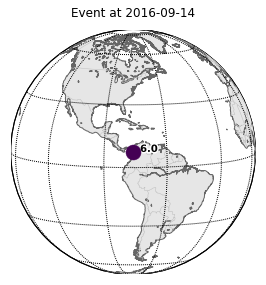

Instaseis Source:
	Origin Time      : 1970-01-01T00:00:00.000000Z
	Longitude        :  -76.2 deg
	Latitude         :    7.4 deg
	Depth            : 1.8e+01 km km
	Moment Magnitude :   5.98
	Scalar Moment    :   1.16e+18 Nm
	Mrr              :   3.06e+17 Nm
	Mtt              :  -8.16e+17 Nm
	Mpp              :   5.10e+17 Nm
	Mrt              :  -6.81e+17 Nm
	Mrp              :  -5.37e+17 Nm
	Mtp              :  -2.90e+17 Nm



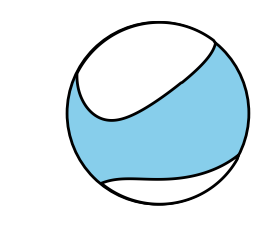

In [2]:
# Retrieve the event data
starttime=obspy.UTCDateTime(2016, 9, 11, 16)
endtime=obspy.UTCDateTime(2016, 9, 14, 4)
minmagnitude=5.9
maxmagnitude=6.1
eventid="GCMT:C201609140158A"
cat=event(starttime=starttime,endtime=endtime,minmagnitude=5.9, maxmagnitude=6.1)
# Make sure starttime and endtime include the complete time for all data (all stations)
starttime=obspy.UTCDateTime(2016, 9, 14, 1, 58, 10)
endtime=obspy.UTCDateTime(2016, 9, 14, 3, 58, 31)

# From work on the moment tensor solution
event_depth=20 #km.
event_latitude,event_longitude=7.236,-76.275

# Near Field / Regional Inversion

We will start doing an inversion just with the regional data.

In [141]:
#Choose a home Directory for project (everything will be saved in this directory)
directory='/Users/jeanbaptistetary/Documents/SSI/'

#Name of the folder that will contain all the Near Field / Regional results.
projectName='NearField'


### Mudpy
At the same time we will produce the input files for the program Mudpy. We will generate the subfaults by using instaseis finite_source function which will give us the locations of the point sources.

In [3]:
# Fault plane parameters
strike,dip,rake=132, 43, 180
evlat1=event_latitude
evlon1=event_longitude
nl=17 #subfaults across length.
nw=17 #subfaults across width.
fault_length_m=50000 # Fault dimension along strike in m
fault_width_m=50000 # Fault dimention along dip in m
rise_time=1.1 # Rise time of subfault source functions in s

finite_source=instaseis.source.FiniteSource.from_Haskell(
        event_latitude, event_longitude, depth_in_m=event_depth*1000,
        strike=strike, dip=dip, rake=rake, M0=7.743e+17,
        fault_length=fault_length_m, fault_width=fault_width_m, rupture_velocity=2500,
        nl=nl, nw=nw,trise=rise_time, tfall=rise_time, dt=0.2, planet_radius=6371000.0, 
        origin_time=cat[0].origins[0].time)

print(finite_source)
print('A point source can be computed as a sum of all point sources weighted by their moment. Instaseis computes the centroid moment tensor by summing over all point sources weighted by their scalar moment')
# Prepare the source time functions (stf)
finite_source.resample_sliprate(dt=finite_source[0].dt, nsamp=512)

finite_source.compute_centroid()
finite_source.CMT.origin_time=cat[0].origins[0].time
print(finite_source.CMT)

print('The hypocenter and epicenter can be found as the fault patch that ruptures first based on the point source that has the smallest timeshift:')
finite_source.find_hypocenter()
print('hypocenter latitude: '+ repr(finite_source.hypocenter_latitude)+
      ', longitude: ' + repr(finite_source.hypocenter_longitude)+
      ', depth: '+ repr(finite_source.hypocenter_depth_in_m / 1e3))


Instaseis Finite Source:
	Moment Magnitude     : 5.86
	Scalar Moment        :   7.74e+17 Nm
	#Point Sources       : 289
	Rupture Duration     :   18.8 s
	Time Shift           :    0.0 s
	Min Depth            : 3886.2 m
	Max Depth            : 36023.6 m
	Hypocenter Depth     : 36023.6 m
	Min Latitude         :    7.0 deg
	Max Latitude         :    7.5 deg
	Hypocenter Latitude  :    7.2 deg
	Min Longitude        :  -76.5 deg
	Max Longitude        :  -76.0 deg
	Hypocenter Longitude :  -76.0 deg

A point source can be computed as a sum of all point sources weighted by their moment. Instaseis computes the centroid moment tensor by summing over all point sources weighted by their scalar moment
Instaseis Source:
	Origin Time      : 2016-09-14T01:58:31.570000Z
	Longitude        :  -76.3 deg
	Latitude         :    7.2 deg
	Depth            : 2.0e+01 km km
	Moment Magnitude :   5.86
	Scalar Moment    :   7.74e+17 Nm
	Mrr              :   2.65e+11 Nm
	Mtt              :  -5.25e+17 Nm
	Mpp        

### Now we plot the subfault with the relocated aftershocks.
We will use these locations also to produce the input for the program mudpy.
Run the following snipped once or just after running the previous, otherwise the min depth will change.

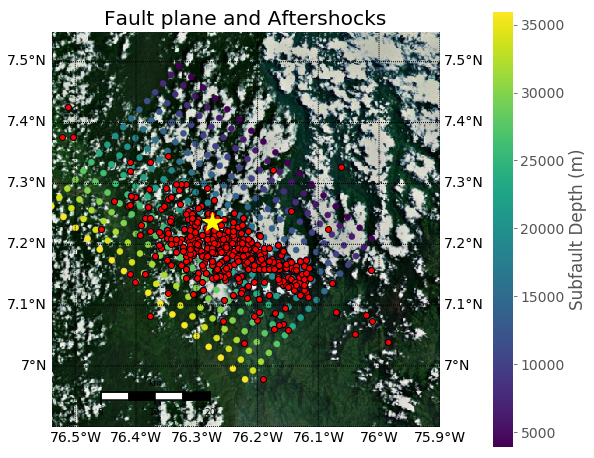

The colors in the fault plane represent their depth. Max depth(km)=36.0 Min Depth(km)= 3.88


In [12]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

fig, ax = plt.subplots(figsize=(8, 8))
map = Basemap(llcrnrlon=-76.54,llcrnrlat=6.9,
              urcrnrlon=-75.9,urcrnrlat=7.55,
              rsphere=(6378137.00,6356752.3142),resolution='c',projection='merc',
              lat_0=evlat1,lon_0=evlon1, suppress_ticks=True,epsg = 3395)


map.drawparallels(np.arange(-90,90,0.1),labels=[1,1,0,1])
map.drawmeridians(np.arange(-100,0,0.1),labels=[1,1,0,1])
map.etopo()
map.drawmapscale(-76.3686, 6.95,-76.1686+0.8,6.95,20, barstyle='fancy', units='km', labelstyle='simple',
                 fillcolor1='w', fillcolor2='black', fontcolor='black')

map.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', service='ESRI_Imagery_World_2D', xpixels = 500, ypixels = 500)

diff=finite_source.max_depth_in_m-finite_source.min_depth_in_m
smallest=finite_source.min_depth_in_m
depth_=finite_source.max_depth_in_m

#Plot the fault plane
depth_arr=np.zeros(nw*nl)
lng_arr=np.zeros(nw*nl)
lat_arr=np.zeros(nw*nl)
for i in range(nl*nw):
    depth_arr[i]=finite_source[i].depth_in_m
    lng_arr[i]=finite_source[i].longitude
    lat_arr[i]=finite_source[i].latitude
    
lng_FP,lat_FP=map(lng_arr,lat_arr)
plt.scatter(lng_FP,lat_FP,c=depth_arr)
cbar=plt.colorbar(pad=0.1, shrink=0.8)
cbar.set_label('Subfault Depth (m)')

#Read Aftershocks
AfterShocks=np.loadtxt(DataDir+'Aftershocks.txt')
lon_AS=AfterShocks[:,0]
lat_AS=AfterShocks[:,1]
depth_AS=AfterShocks[:,2]
jj2,hh2= map(lon_AS,lat_AS)
plt.scatter(jj2,hh2, c=depth_AS)
map.plot(jj2,hh2,'o', markersize=6, markeredgecolor="black", color='red')

#plot the hypocenter
jj1, hh1 = map(event_longitude ,event_latitude)
map.plot(jj1,hh1, '*',markersize=20, color='yellow')

plt.title(r'Fault plane and Aftershocks')
plt.tight_layout()
plt.show()

print('The colors in the fault plane represent their depth. Max depth(km)='+repr(finite_source.max_depth_in_m/1000)[:4]+' Min Depth(km)= '+repr(finite_source.min_depth_in_m/1000)[:4])


Now we generate the files that Mudpy reads as an input for generating the green functions and synthetics. It needs as an input the subfault locations and depth which we calculated previously. It makes a plot of how the program reads the fault plane in order to check that it is as we want it to be.

We make sure that the event data is the same that the program will use to calculate the synthetics and perform the inversion. Numbers of subfaults across length nl and across width nw are entered to the run file. 

## Plotting the Results - Near Field / Regional Inversion

Which iteration you do want to plot (0-199)?25
Inversion number: 0025
Lowpassing
Lowpassing


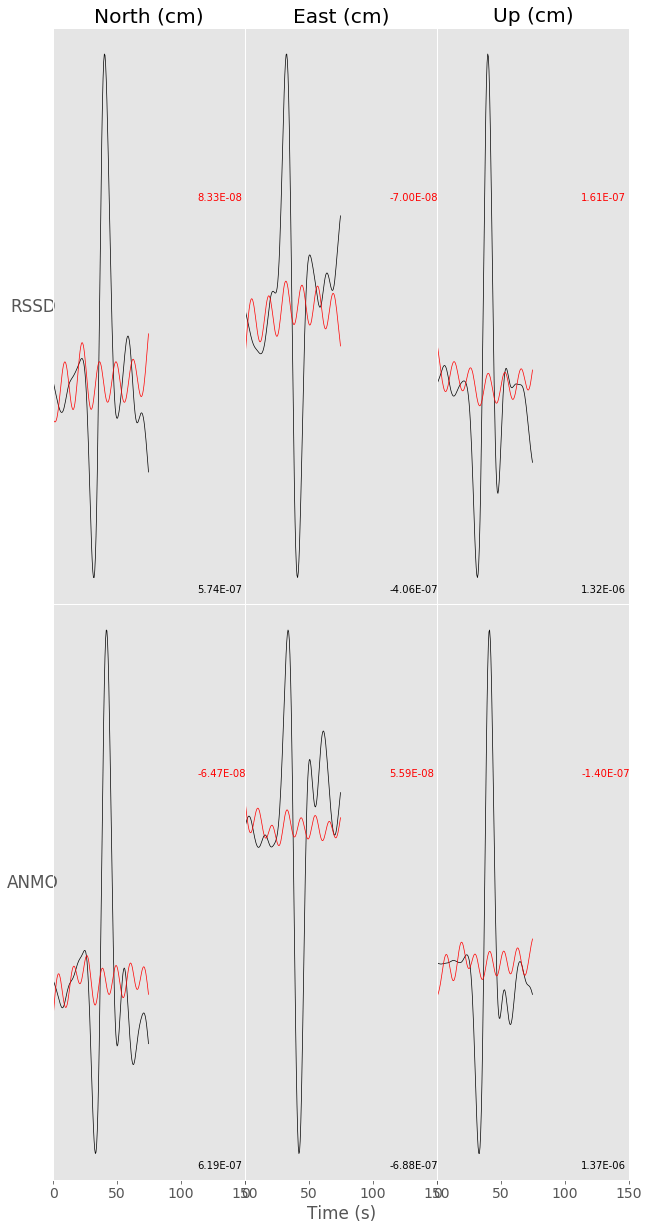

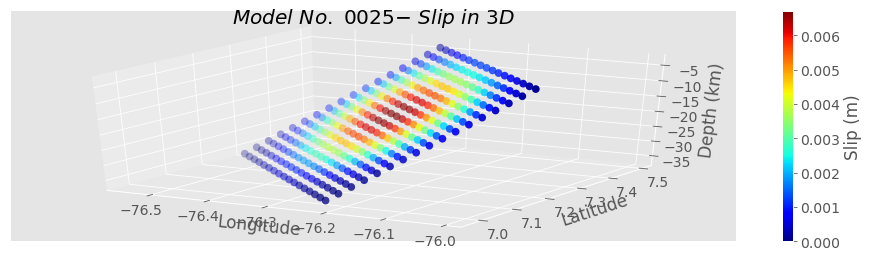

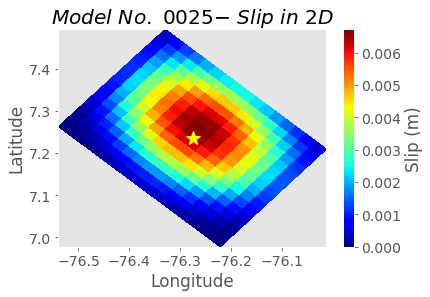

Mean slip in m is: 0.0025201573390808067
np.logspace(-6,0,num=10)#Set np.logspace(-8,2,num=20)#Se
reg_coef: t,s [-8, 2, 20] [-6, 0, 10]
Min ABIC= -20959.42513510947 84
The minimum ABIC is at dot: lambda_s= 5 and lambda_t= 9
Chosen ABIC= -20280.60627606927
The green triangle shows the selected regulatization coefficients
The green star shows the regulatization coeficients with minimum ABIC


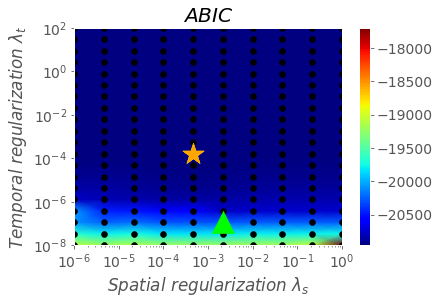

... working on subfault 0 of 289
... working on subfault 10 of 289
... working on subfault 20 of 289
... working on subfault 30 of 289
... working on subfault 40 of 289
... working on subfault 50 of 289
... working on subfault 60 of 289
... working on subfault 70 of 289
... working on subfault 80 of 289
... working on subfault 90 of 289
... working on subfault 100 of 289
... working on subfault 110 of 289
... working on subfault 120 of 289
... working on subfault 130 of 289
... working on subfault 140 of 289
... working on subfault 150 of 289
... working on subfault 160 of 289
... working on subfault 170 of 289
... working on subfault 180 of 289
... working on subfault 190 of 289
... working on subfault 200 of 289
... working on subfault 210 of 289
... working on subfault 220 of 289
... working on subfault 230 of 289
... working on subfault 240 of 289
... working on subfault 250 of 289
... working on subfault 260 of 289
... working on subfault 270 of 289
... working on subfault 280 of 

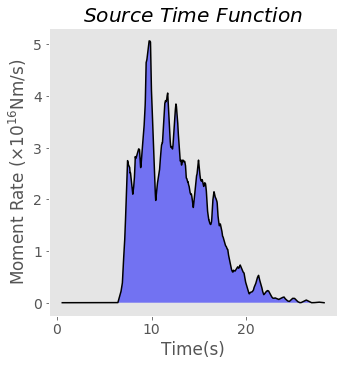

Do you want to plot another iteration (y/n)?y
Which iteration you do want to plot (0-199)?22
Inversion number: 0022
Lowpassing
Lowpassing


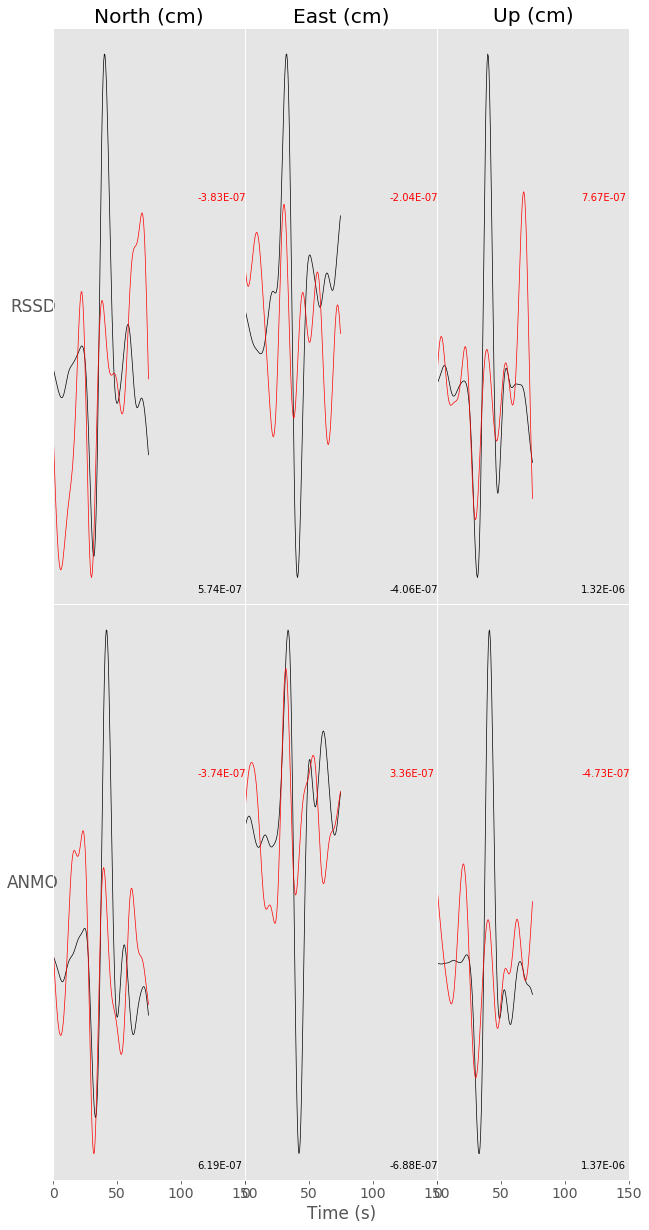

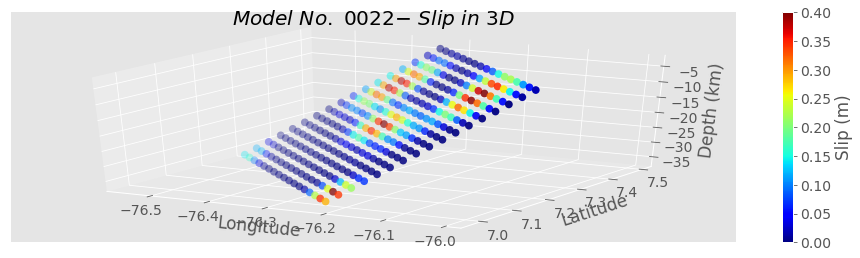

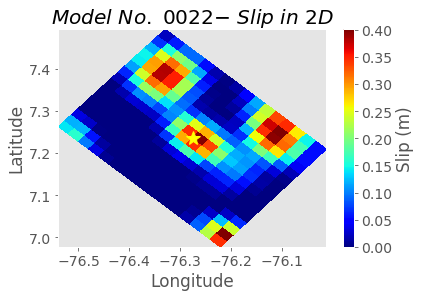

Mean slip in m is: 0.09043488391465422
np.logspace(-6,0,num=10)#Set np.logspace(-8,2,num=20)#Se
reg_coef: t,s [-8, 2, 20] [-6, 0, 10]
Min ABIC= -20959.42513510947 84
The minimum ABIC is at dot: lambda_s= 5 and lambda_t= 9
Chosen ABIC= -20186.25117263503
The green triangle shows the selected regulatization coefficients
The green star shows the regulatization coeficients with minimum ABIC


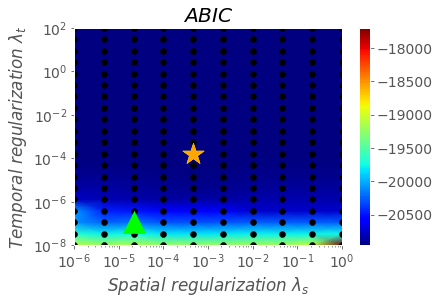

... working on subfault 0 of 289
... working on subfault 10 of 289
... working on subfault 20 of 289
... working on subfault 30 of 289
... working on subfault 40 of 289
... working on subfault 50 of 289
... working on subfault 60 of 289
... working on subfault 70 of 289
... working on subfault 80 of 289
... working on subfault 90 of 289
... working on subfault 100 of 289
... working on subfault 110 of 289
... working on subfault 120 of 289
... working on subfault 130 of 289
... working on subfault 140 of 289
... working on subfault 150 of 289
... working on subfault 160 of 289
... working on subfault 170 of 289
... working on subfault 180 of 289
... working on subfault 190 of 289
... working on subfault 200 of 289
... working on subfault 210 of 289
... working on subfault 220 of 289
... working on subfault 230 of 289
... working on subfault 240 of 289
... working on subfault 250 of 289
... working on subfault 260 of 289
... working on subfault 270 of 289
... working on subfault 280 of 

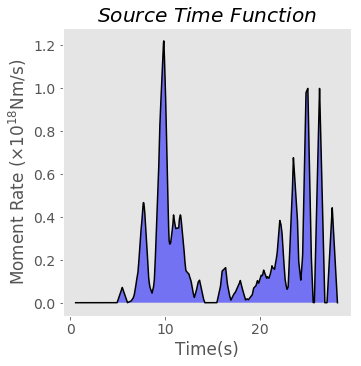

Do you want to plot another iteration (y/n)?n


In [9]:
# Plots of the main results for a given iteration
# Including: waveform fit between synthetics and observed data, slip distribution, 2d ABIC plot, STF
# The figures will be saved in directory+projectName+plots
home=directory
project=projectName
run_name='mutata'

epi=[event_longitude, event_latitude]
dimslip=[nl,nw]
lf=0.09
# The plotting function for the source time function in MudPy has a bug in it. See the Matlab code to get the correct
# STF
plotResults(home,project,run_name,epi,dimslip,lf,maxt=150,Plotsyn=True,Plotsli=True,Plotabc=True)



/Users/jeanbaptistetary/Documents/DavidNaranjo/MudPy/src/python/mudpy/view.py:2742: RuntimeWarning: invalid value encountered in divide
  ds=ds/((ds**2+ss**2)**0.5)


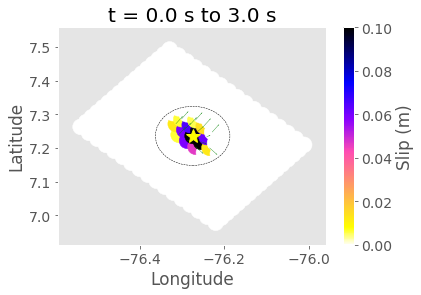

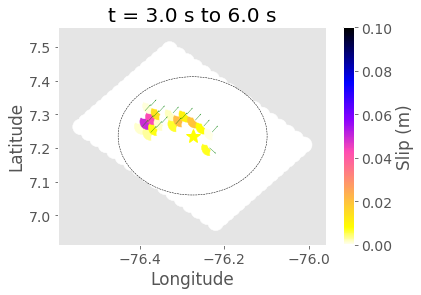

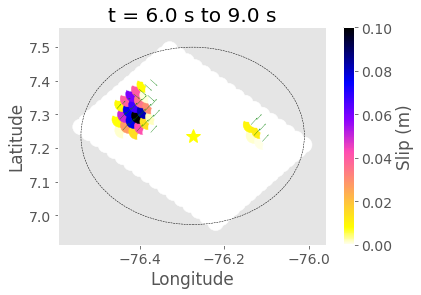

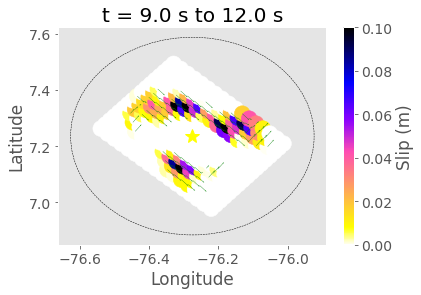

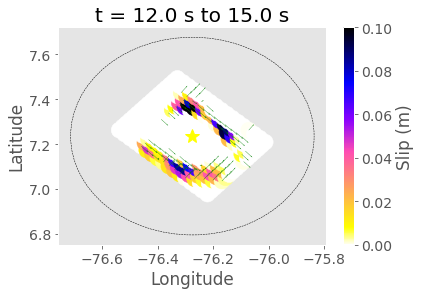

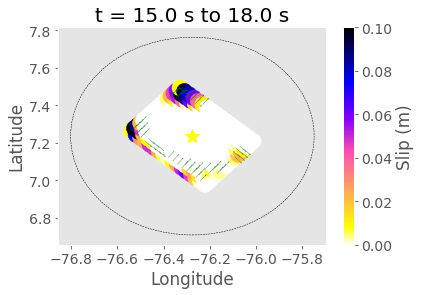

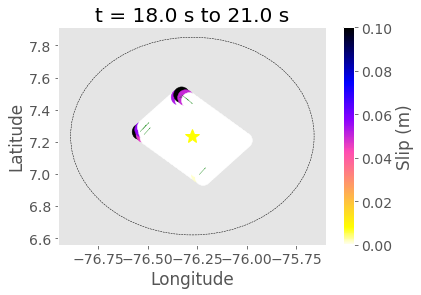

... working on subfault 0 of 289
... working on subfault 10 of 289
... working on subfault 20 of 289
... working on subfault 30 of 289
... working on subfault 40 of 289
... working on subfault 50 of 289
... working on subfault 60 of 289
... working on subfault 70 of 289
... working on subfault 80 of 289
... working on subfault 90 of 289
... working on subfault 100 of 289
... working on subfault 110 of 289
... working on subfault 120 of 289
... working on subfault 130 of 289
... working on subfault 140 of 289
... working on subfault 150 of 289
... working on subfault 160 of 289
... working on subfault 170 of 289
... working on subfault 180 of 289
... working on subfault 190 of 289
... working on subfault 200 of 289
... working on subfault 210 of 289
... working on subfault 220 of 289
... working on subfault 230 of 289
... working on subfault 240 of 289
... working on subfault 250 of 289
... working on subfault 260 of 289
... working on subfault 270 of 289
... working on subfault 280 of 

(array([[13.3083    , 13.30890506, 13.30951012, ..., 19.35708988,
         19.35769494, 19.3583    ],
        [12.5059    , 12.50650506, 12.50711012, ..., 18.55468988,
         18.55529494, 18.5559    ],
        [11.7625    , 11.76310506, 11.76371012, ..., 17.81128988,
         17.81189494, 17.8125    ],
        ...,
        [11.765     , 11.76560506, 11.76621012, ..., 17.81378988,
         17.81439494, 17.815     ],
        [12.5065    , 12.50710506, 12.50771012, ..., 18.55528988,
         18.55589494, 18.5565    ],
        [13.3104    , 13.31100506, 13.31161012, ..., 19.35918988,
         19.35979494, 19.3604    ]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.42720019e+14, 7.13600094e+13, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.28621569e+14, 6.43107846e+13, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.31659110e+13, 2.15829555e+13, 0.00000000e+00],
        ...,


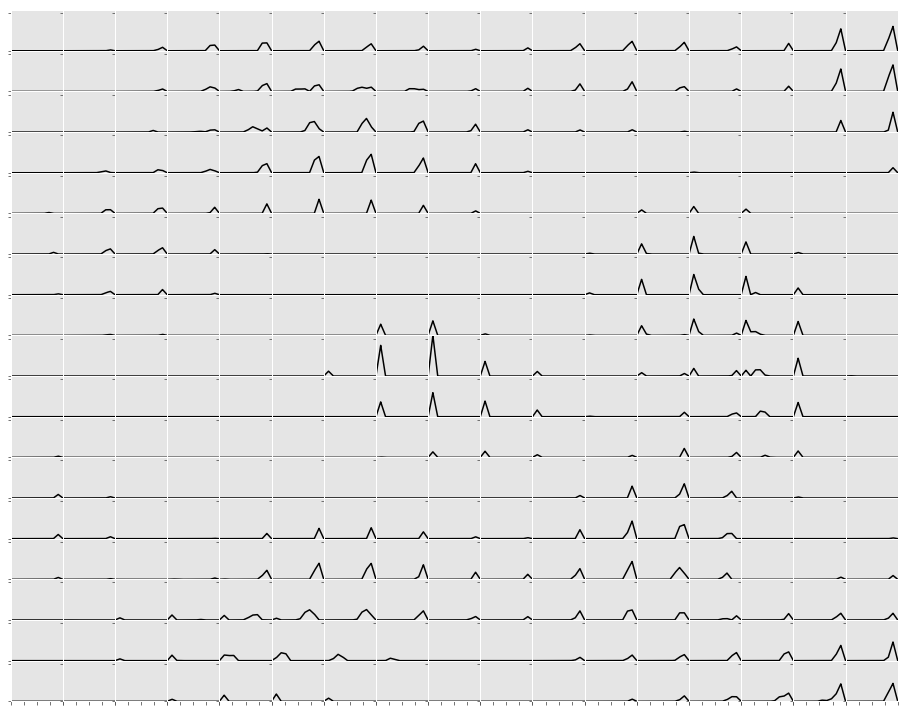

In [21]:
# Additional plotting:
from mudpy import view
# Path to rupture file to plot, path to plots and epicenter parameters
pathinv = directory+projectName+'/output/inverse_models/models/mutata.0112.inv'
pathout = directory+projectName+'/plots/'
epicenter=[event_longitude,event_latitude,event_depth]

# To get *.sliprate files (not needed yet)
#gmttools.make_sliprate_ruptfiles(pathinv,nl,nw,epicenter,pathout,15,3)
# To get *.slip files (not needed yet)
#gmttools.make_slip_slice(pathinv,nl,nw,epicenter,pathout,15,3)

# Slip as a function of time to check subfault activation timing (and rupture velocity)
# dt: duration of slices, delta_t: sampling interval of STF, cumul: if =0 cumulative slip else no, 
# vl and vm: lower and higher bounds of colorbar for plotting slip, vr: max rupture velocity in km/s
ruptslice(pathinv,pathout,epicenter,3,0.2,0,0,0.1,3.24)

# Source time functions for all subfaults
# None: covfile, 0: beta (rotate slip components), (5,1): rupture velocity limits, False/True: shade (true: very slow)
view.tile_moment(pathinv,epicenter,nl,nw,None,0,(5,1),False)


## Far Field

For the velocity model, the Global velocity model ak135f is taken as a reference

In [4]:
#Choose a home Directory for project (everything will be saved in this directory)
directory='/Users/jeanbaptistetary/Documents/SSI/'

#Name of the folder that will contain all the Near Field / Regional results.
projectName='FarField'


## Plotting the Results - Far Field Inversion

Which iteration you do want to plot (0-199)?62
Inversion number: 0062
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing


/anaconda2/envs/obspy/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


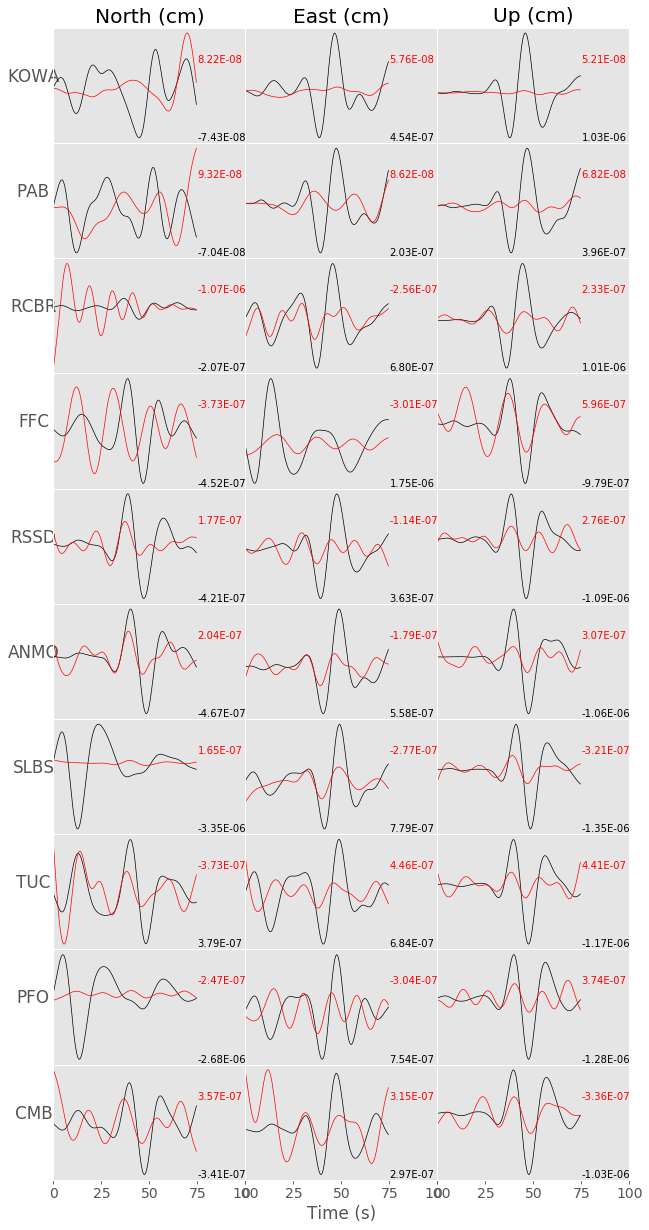

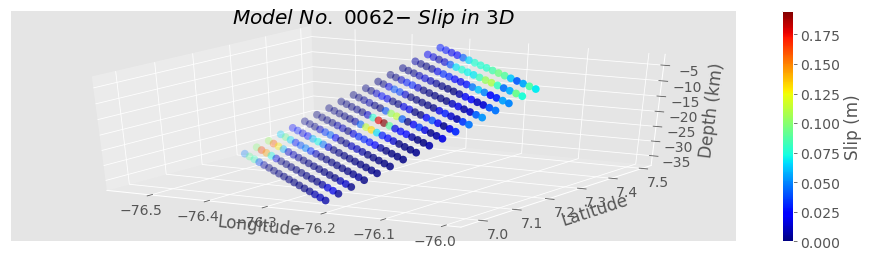

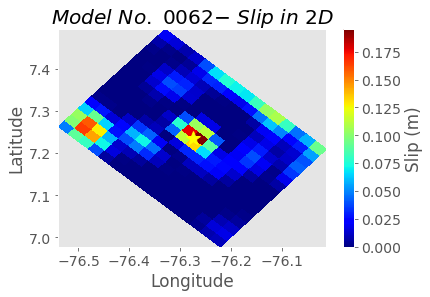

Mean slip in m is: 0.025082821549377014
np.logspace(-6,0,num=10)#Set np.logspace(-8,2,num=20)#Se
reg_coef: t,s [-8, 2, 20] [-6, 0, 10]
Min ABIC= -94881.97547870112 94
The minimum ABIC is at dot: lambda_s= 5 and lambda_t= 10
Chosen ABIC= -94520.68362354225
The green triangle shows the selected regulatization coefficients
The green star shows the regulatization coeficients with minimum ABIC


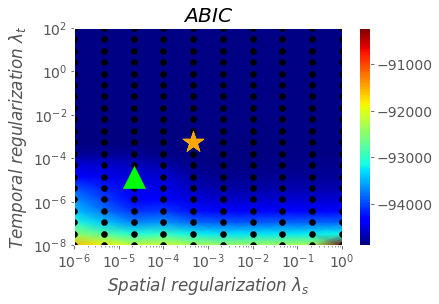

... working on subfault 0 of 289
... working on subfault 10 of 289
... working on subfault 20 of 289
... working on subfault 30 of 289
... working on subfault 40 of 289
... working on subfault 50 of 289
... working on subfault 60 of 289
... working on subfault 70 of 289
... working on subfault 80 of 289
... working on subfault 90 of 289
... working on subfault 100 of 289
... working on subfault 110 of 289
... working on subfault 120 of 289
... working on subfault 130 of 289
... working on subfault 140 of 289
... working on subfault 150 of 289
... working on subfault 160 of 289
... working on subfault 170 of 289
... working on subfault 180 of 289
... working on subfault 190 of 289
... working on subfault 200 of 289
... working on subfault 210 of 289
... working on subfault 220 of 289
... working on subfault 230 of 289
... working on subfault 240 of 289
... working on subfault 250 of 289
... working on subfault 260 of 289
... working on subfault 270 of 289
... working on subfault 280 of 

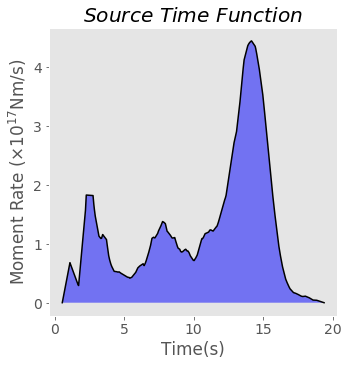

Do you want to plot another iteration (y/n)?n


In [5]:
# Plots of the main results for a given iteration
# Including: waveform fit between synthetics and observed data, slip distribution, 2d ABIC plot, STF
# The figures will be saved in directory+projectName+plots
home=directory
project=projectName
run_name='mutata'

epi=[event_longitude, event_latitude]
dimslip=[nl,nw]
lf=0.09
# The plotting function for the source time function in MudPy has a bug in it. See the Matlab code to get the correct
# STF
plotResults(home,project,run_name,epi,dimslip,lf,maxt=100,Plotsyn=True,Plotsli=True,Plotabc=True)


/Users/jeanbaptistetary/Documents/DavidNaranjo/MudPy/src/python/mudpy/view.py:2742: RuntimeWarning: invalid value encountered in divide
  ds=ds/((ds**2+ss**2)**0.5)


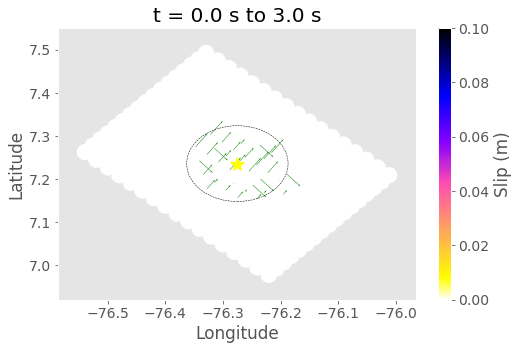

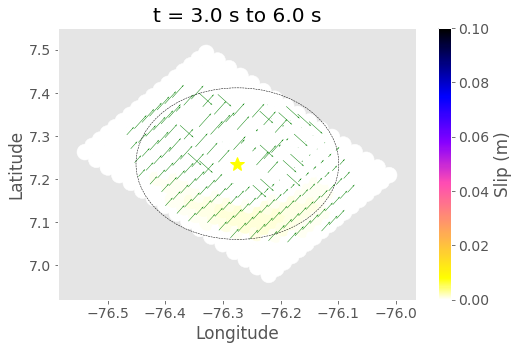

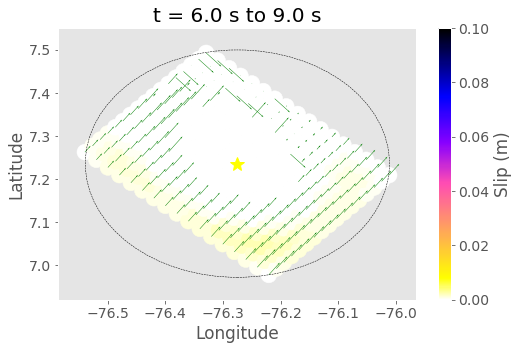

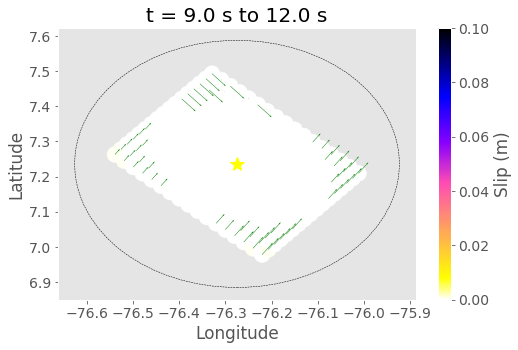

... working on subfault 0 of 289
... working on subfault 10 of 289
... working on subfault 20 of 289
... working on subfault 30 of 289
... working on subfault 40 of 289
... working on subfault 50 of 289
... working on subfault 60 of 289
... working on subfault 70 of 289
... working on subfault 80 of 289
... working on subfault 90 of 289
... working on subfault 100 of 289
... working on subfault 110 of 289
... working on subfault 120 of 289
... working on subfault 130 of 289
... working on subfault 140 of 289
... working on subfault 150 of 289
... working on subfault 160 of 289
... working on subfault 170 of 289
... working on subfault 180 of 289
... working on subfault 190 of 289
... working on subfault 200 of 289
... working on subfault 210 of 289
... working on subfault 220 of 289
... working on subfault 230 of 289
... working on subfault 240 of 289
... working on subfault 250 of 289
... working on subfault 260 of 289
... working on subfault 270 of 289
... working on subfault 280 of 

(array([[ 8.3177    ,  8.31797503,  8.31825006, ..., 11.06714994,
         11.06742497, 11.0677    ],
        [ 7.8162    ,  7.81647503,  7.81675006, ..., 10.56564994,
         10.56592497, 10.5662    ],
        [ 7.3516    ,  7.35187503,  7.35215006, ..., 10.10104994,
         10.10132497, 10.1016    ],
        ...,
        [ 7.3531    ,  7.35337503,  7.35365006, ..., 10.10254994,
         10.10282497, 10.1031    ],
        [ 7.8166    ,  7.81687503,  7.81715006, ..., 10.56604994,
         10.56632497, 10.5666    ],
        [ 8.319     ,  8.31927503,  8.31955006, ..., 11.06844994,
         11.06872497, 11.069     ]]),
 array([[0.00000000e+00, 1.09971158e+11, 2.19942316e+11, ...,
         9.89054774e+10, 4.94527387e+10, 0.00000000e+00],
        [0.00000000e+00, 1.64983087e+11, 3.29966173e+11, ...,
         1.55298764e+11, 7.76493820e+10, 0.00000000e+00],
        [0.00000000e+00, 1.79580330e+11, 3.59160661e+11, ...,
         1.70263191e+11, 8.51315954e+10, 0.00000000e+00],
        ...,


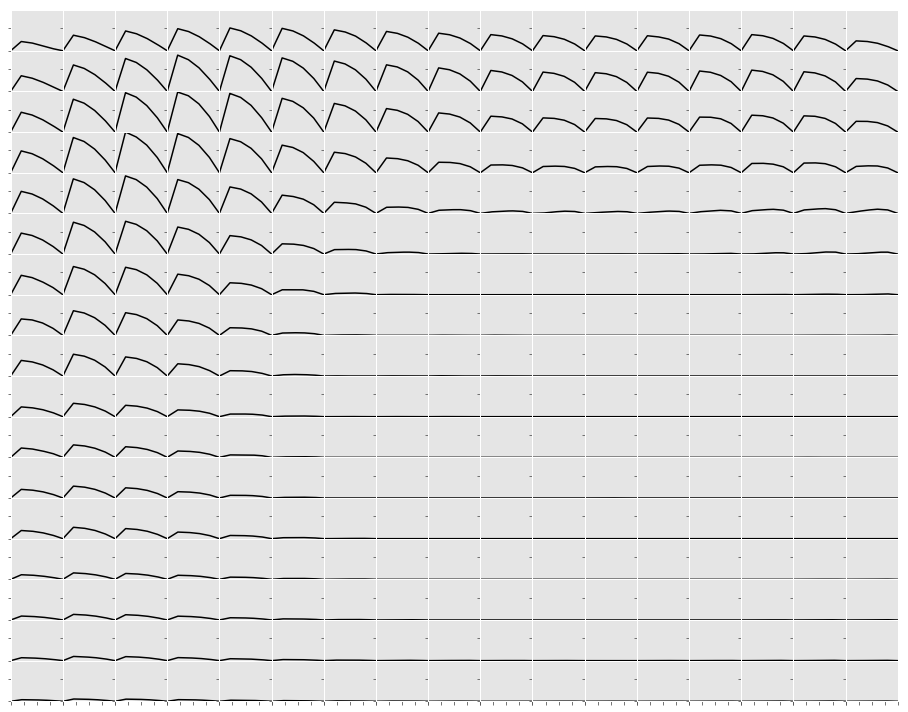

In [117]:
# Additional plotting:
from mudpy import view
# Path to rupture file to plot, path to plots and epicenter parameters
pathinv = directory+projectName+'/output/inverse_models/models/mutata.0000.inv'
pathout = directory+projectName+'/plots/'
epicenter=[event_longitude,event_latitude,event_depth]

# To get *.sliprate files (not needed yet)
#gmttools.make_sliprate_ruptfiles(pathinv,nl,nw,epicenter,pathout,15,3)
# To get *.slip files (not needed yet)
#gmttools.make_slip_slice(pathinv,nl,nw,epicenter,pathout,15,3)

# Slip as a function of time to check subfault activation timing (and rupture velocity)
# dt: duration of slices, delta_t: sampling interval of STF, cumul: if =0 cumulative slip else no, 
# vl and vm: lower and higher bounds of colorbar for plotting slip, vr: max rupture velocity in km/s
ruptslice(pathinv,pathout,epicenter,3,0.2,0,0,0.1,3.24)

# Source time functions for all subfaults
# None: covfile, 0: beta (rotate slip components), (5,1): rupture velocity limits, False/True: shade (true: very slow)
view.tile_moment(pathinv,epicenter,nl,nw,None,0,(5,1),False)

## Joint inversion - Near/Regional field + Far Field

For the velocity models, use different velocity models for each part (those defined before)

In [146]:
#Choose a home Directory for project (everything will be saved in this directory)
directory='/Users/jeanbaptistetary/Documents/SSI/'

#Name of the folder that will contain all the Near Field / Regional results.
projectName='JointInv'


## Plotting the Results - Joint Inversion

Which iteration you do want to plot (0-199)?50
Inversion number: 0050
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing
Lowpassing


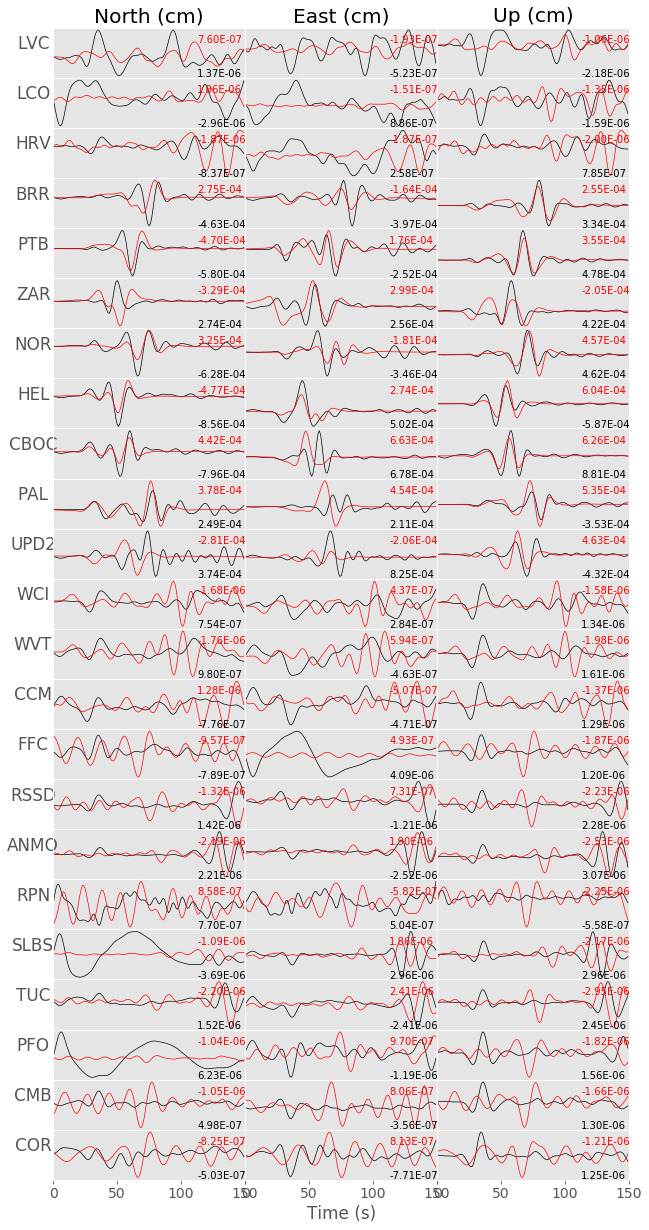

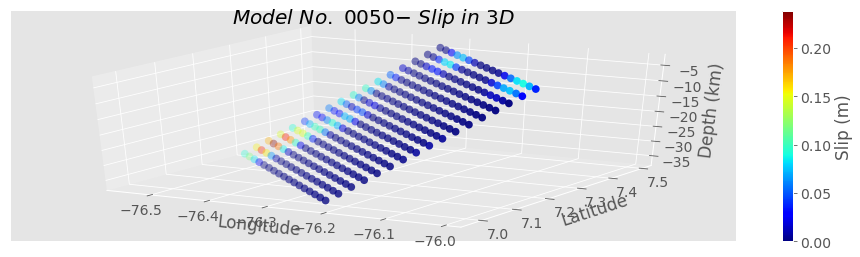

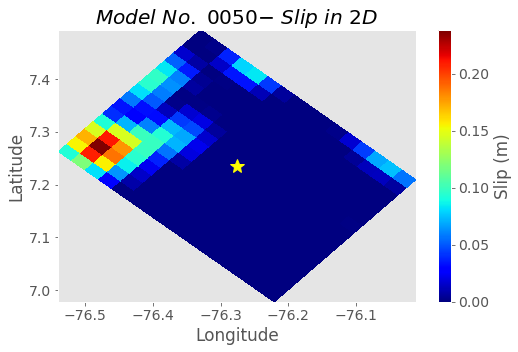

Mean slip in m is: 0.02056115303881893
np.logspace(-3,2,num=20)#Set np.logspace(-3,2,num=10)#Se
reg_coef: t,s [-3, 2, 10] [-3, 2, 20]
Min ABIC= -102360.1509046708 50
The minimum ABIC is at dot: lambda_s= 11 and lambda_t= 3
Chosen ABIC= -102360.1509046708
The green triangle shows the selected regulatization coefficients
The green star shows the regulatization coeficients with minimum ABIC


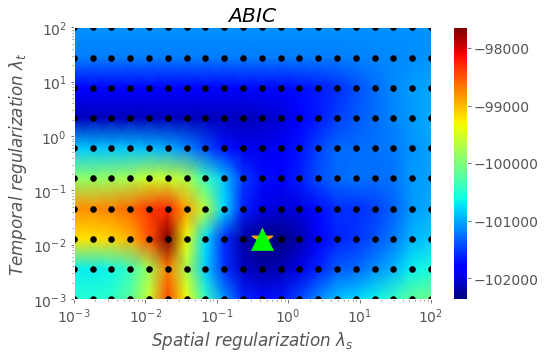

... working on subfault 0 of 289
... working on subfault 10 of 289
... working on subfault 20 of 289
... working on subfault 30 of 289
... working on subfault 40 of 289
... working on subfault 50 of 289
... working on subfault 60 of 289
... working on subfault 70 of 289
... working on subfault 80 of 289
... working on subfault 90 of 289
... working on subfault 100 of 289
... working on subfault 110 of 289
... working on subfault 120 of 289
... working on subfault 130 of 289
... working on subfault 140 of 289
... working on subfault 150 of 289
... working on subfault 160 of 289
... working on subfault 170 of 289
... working on subfault 180 of 289
... working on subfault 190 of 289
... working on subfault 200 of 289
... working on subfault 210 of 289
... working on subfault 220 of 289
... working on subfault 230 of 289
... working on subfault 240 of 289
... working on subfault 250 of 289
... working on subfault 260 of 289
... working on subfault 270 of 289
... working on subfault 280 of 

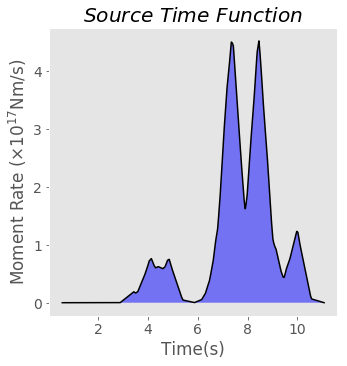

Do you want to plot another iteration (y/n)?n


In [151]:
# Plots of the main results for a given iteration
# Including: waveform fit between synthetics and observed data, slip distribution, 2d ABIC plot, STF
# The figures will be saved in directory+projectName+plots
home=directory
project=projectName
run_name='mutata'

epi=[event_longitude, event_latitude]
dimslip=[nl,nw]
lf=0.10
# The plotting function for the source time function in MudPy has a bug in it. See the Matlab code to get the correct
# STF
plotResults(home,project,run_name,epi,dimslip,lf,maxt=150,Plotsyn=True,Plotsli=True,Plotabc=True)

/anaconda2/envs/obspy/lib/python2.7/site-packages/matplotlib/quiver.py:648: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/anaconda2/envs/obspy/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda2/envs/obspy/lib/python2.7/site-packages/matplotlib/quiver.py:719: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/anaconda2/envs/obspy/lib/python2.7/site-packages/matplotlib/quiver.py:733: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


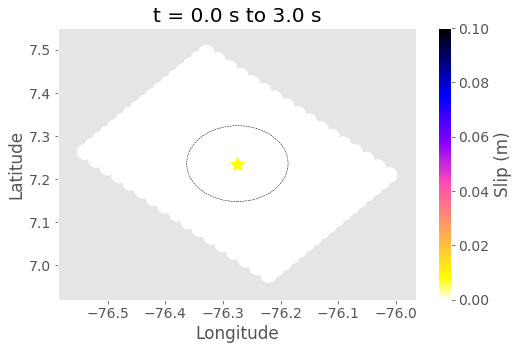

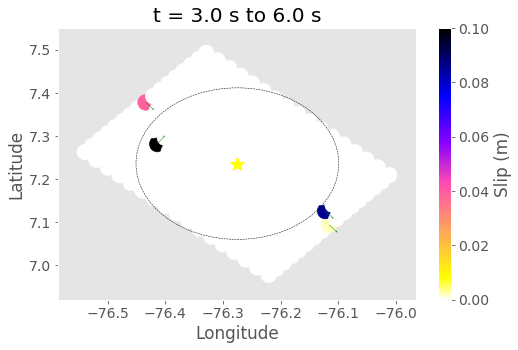

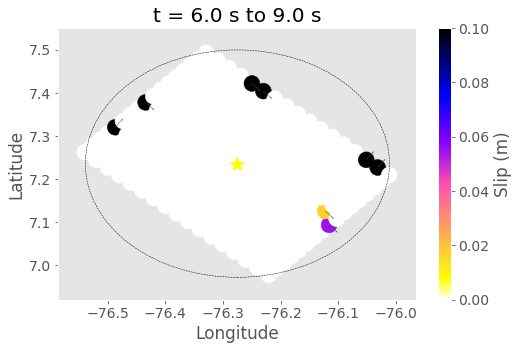

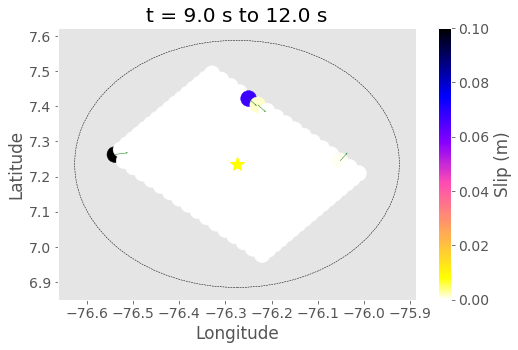

... working on subfault 0 of 289
... working on subfault 10 of 289
... working on subfault 20 of 289
... working on subfault 30 of 289
... working on subfault 40 of 289
... working on subfault 50 of 289
... working on subfault 60 of 289
... working on subfault 70 of 289
... working on subfault 80 of 289
... working on subfault 90 of 289
... working on subfault 100 of 289
... working on subfault 110 of 289
... working on subfault 120 of 289
... working on subfault 130 of 289
... working on subfault 140 of 289
... working on subfault 150 of 289
... working on subfault 160 of 289
... working on subfault 170 of 289
... working on subfault 180 of 289
... working on subfault 190 of 289
... working on subfault 200 of 289
... working on subfault 210 of 289
... working on subfault 220 of 289
... working on subfault 230 of 289
... working on subfault 240 of 289
... working on subfault 250 of 289
... working on subfault 260 of 289
... working on subfault 270 of 289
... working on subfault 280 of 

(array([[ 8.3177    ,  8.31797503,  8.31825006, ..., 11.06714994,
         11.06742497, 11.0677    ],
        [ 7.8162    ,  7.81647503,  7.81675006, ..., 10.56564994,
         10.56592497, 10.5662    ],
        [ 7.3516    ,  7.35187503,  7.35215006, ..., 10.10104994,
         10.10132497, 10.1016    ],
        ...,
        [ 7.3531    ,  7.35337503,  7.35365006, ..., 10.10254994,
         10.10282497, 10.1031    ],
        [ 7.8166    ,  7.81687503,  7.81715006, ..., 10.56604994,
         10.56632497, 10.5666    ],
        [ 8.319     ,  8.31927503,  8.31955006, ..., 11.06844994,
         11.06872497, 11.069     ]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         7.47515195e+14, 3.73757598e+14, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,


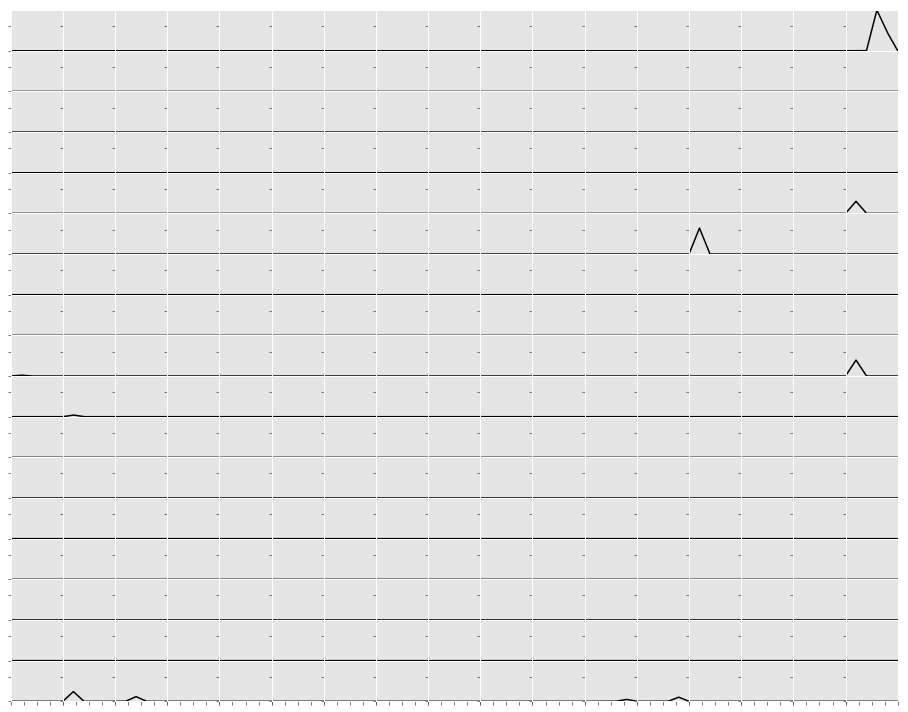

In [152]:
# Additional plotting:
from mudpy import view
# Path to rupture file to plot, path to plots and epicenter parameters
pathinv = directory+projectName+'/output/inverse_models/models/mutata.0000.inv'
pathout = directory+projectName+'/plots/'
epicenter=[event_longitude,event_latitude,event_depth]

# To get *.sliprate files (not needed yet)
#gmttools.make_sliprate_ruptfiles(pathinv,nl,nw,epicenter,pathout,15,3)
# To get *.slip files (not needed yet)
#gmttools.make_slip_slice(pathinv,nl,nw,epicenter,pathout,15,3)

# Slip as a function of time to check subfault activation timing (and rupture velocity)
# dt: duration of slices, delta_t: sampling interval of STF, cumul: if =0 cumulative slip else no, 
# vl and vm: lower and higher bounds of colorbar for plotting slip, vr: max rupture velocity in km/s
ruptslice(pathinv,pathout,epicenter,3,0.2,0,0,0.1,3.24)

# Source time functions for all subfaults
# None: covfile, 0: beta (rotate slip components), (5,1): rupture velocity limits, False/True: shade (true: very slow)
view.tile_moment(pathinv,epicenter,nl,nw,None,0,(5,1),False)